In [2]:
import plotly.express as px
from sqlalchemy import create_engine, engine
import pandas as pd
import numpy as np
import boto3
import os
from dotenv import dotenv_values, load_dotenv


In [18]:
data = ["2023-05-22 06:45:34.22222", "2019-05-22 15:45:34.22222", "2015-05-22 20:45:34.22222", "2010-05-22 14:45:34.22222"]
riders_day_df = pd.DataFrame(data, columns=['start_time'])
total = riders_day_df["start_time"].count()
print_line = f"Total number of riders in the last 24 hours: {total}"


In [19]:
data = [["2023-05-22 06:45:34.22222", "male"], ["2019-05-22 15:45:34.22222", "male"], ["2015-05-22 20:45:34.22222", "female"], ["2010-05-22 14:45:34.22222", "male"]]
riders_day_gender_df = pd.DataFrame(data, columns=['start_time', 'gender'])
gender_count = riders_day_gender_df.groupby('gender')['start_time'].count().reset_index(name='count')
fig = px.bar(gender_count, x = 'gender', y = 'count', title="Gender split between riders in the last 24 hours")
# fig.update_layout(
#     xaxis_title='Gender',
#     yaxis_title='Count'
# )

In [20]:
data = [["2023-05-16 06:45:34.22222", "2000-04-22"], ["2023-05-16 15:45:34.22222", "1992-08-10"], ["2023-05-16 20:45:34.22222", "2004-06-14"], ["2023-05-16 14:45:34.22222", "1999-12-25"]]
riders_day_gender_df = pd.DataFrame(data, columns=['start_time', 'dob'])
riders_day_gender_df['start_time'] = pd.to_datetime(riders_day_gender_df['start_time'])
riders_day_gender_df['dob'] = pd.to_datetime(riders_day_gender_df['dob'])
riders_day_gender_df['age'] = ((riders_day_gender_df['start_time'] - riders_day_gender_df['dob']).dt.days.astype(float)) * 0.00273973 #converts to normal number
riders_day_gender_df['age'] = riders_day_gender_df['age'].apply(np.floor)
print(riders_day_gender_df)

                  start_time        dob   age
0 2023-05-16 06:45:34.222220 2000-04-22  23.0
1 2023-05-16 15:45:34.222220 1992-08-10  30.0
2 2023-05-16 20:45:34.222220 2004-06-14  18.0
3 2023-05-16 14:45:34.222220 1999-12-25  23.0


In [21]:
bins = [10, 20, 30, 40, 50, 60, 70, 105]
labels = ['10-20', '21-30', '31-40', '41-50', '51-60', '61-70', '71+']
age_groups = pd.cut(riders_day_gender_df['age'], bins=bins, labels=labels, right=True)
age_group_count = riders_day_gender_df.groupby([age_groups])['start_time'].count().reset_index(name='count')
age_fig = px.bar(age_group_count, x = 'age', y = 'count', title="Age group split between riders in the last 24 hours")
# age_fig.update_layout(
#     xaxis_title='Age',
#     yaxis_title='Count'
# )

In [121]:
style = """<style>\nh1 {color : purple;text-align: center;}\np1 {text-align: center;}\n.heading {display: flex;flex-direction: column;align-items: center; margin-left: -100px;}

</style>"""


In [23]:
data = [["2023-05-16 06:45:34.22222", "84", "11.22896664"], ["2023-05-16 15:45:34.22222", "85", "12.54785501"], ["2023-05-16 20:45:34.22222", "63", "1.648772319"], ["2023-05-16 14:45:34.22222", "72", "8.962429663"]]
riders_day_reading_df = pd.DataFrame(data, columns=['start_time', 'avg_heart_rate', 'avg_power'])
heart_fig = px.scatter(riders_day_reading_df, x="start_time", y="avg_heart_rate", color="avg_heart_rate", title="Average heart rate in the past day")
heart_fig.update_layout(
xaxis_title ="Time",
yaxis_title ="Heart rate"
)
power_fig = px.scatter(riders_day_reading_df, x="start_time", y="avg_power", color="avg_power", title="Average power in the past day")
power_fig.update_layout(
xaxis_title ="Time",
yaxis_title ="Power"
)
with open('report_graph.html', 'w') as f:
    f.write(f'<html>\n<head>{style}\n<title>Daily Report</title>\n<link rel="stylesheet" href="./style.css">\n</head>\n<body>\n<div class="heading">\n<h1>Daily report</h1>\n<p1>{print_line}</p1>\n</div>\n<div class="container" >')
    f.write(fig.to_html(full_html=False, include_plotlyjs='cdn'))
    f.write(age_fig.to_html(full_html=False, include_plotlyjs='cdn'))
    f.write(heart_fig.to_html(full_html=False, include_plotlyjs='cdn'))
    f.write(power_fig.to_html(full_html=False, include_plotlyjs='cdn'))
    f.write("\n</body>\n</html>")

print(print_line)

Total number of riders in the last 24 hours: 4


In [39]:
import boto3
from botocore.exceptions import ClientError
from email.mime.multipart import MIMEMultipart
from email.mime.text import MIMEText
from email.mime.application import MIMEApplication
from xhtml2pdf import pisa
load_dotenv()
config = os.environ
region = "eu-west-2"
sws_user = config["ACCESS_KEY"]
sws_key = config["SECRET_KEY"]
subject = 'Sending email with Attachment '
body = "Dear Sir/Madam,\n\nPlease find our daily report file attached in the form of a html file.\n\n!!PLEASE DOWNLOAD FILE FIRST!!\n\nKind regards,\n\nTeam"

client = boto3.client(service_name = 'ses', region_name = region, aws_access_key_id = sws_user, aws_secret_access_key = sws_key)

   
message = MIMEMultipart()
message['Subject'] = subject
message['From'] = "trainee.dani.rahulan@sigmalabs.co.uk"
message['To'] = "trainee.dani.rahulan@sigmalabs.co.uk"

# message body
body_html = f"<pre>{body}</pre>"
part = MIMEText(body_html, 'html')
message.attach(part)

attachmentUrl = "./report_graph.pdf"
with open(attachmentUrl, 'r', encoding="latin-1") as file:
    # part_content = file.read()
    part = MIMEApplication(file.read(), 'pdf')
    part.add_header("Content-Disposition",
                        "attachment",
                        filename=os.path.basename(attachmentUrl))
message.attach(part)  
destination = { 'ToAddresses' : [message['To']], 'CcAddresses' : [], 'BccAddresses' : []}

try:
    result = client.send_raw_email(Source = "trainee.dani.rahulan@sigmalabs.co.uk", Destinations = ["trainee.dani.rahulan@sigmalabs.co.uk","trainee.mohammed.simjee@sigmalabs.co.uk", "trainee.ben.corrigan@sigmalabs.co.uk","dan.keefe@sigmalabs.co.uk"], RawMessage = {'Data': message.as_string(),})
    print( {'message': 'error','status' : 'fail'} if 'ErrorResponse' in result else {'message': 'mail sent successfully', 'status' : 'success'})
except ClientError as e:
    print ({'message': e.response['Error']['Message'],'status' : 'fail'})

{'message': 'mail sent successfully', 'status': 'success'}


In [38]:
from xhtml2pdf import pisa  
result_file = open("report_graph.pdf", "w+b")
with open ("./report_graph.html") as html_file:
    html_text = html_file.read()
pisa_status = pisa.CreatePDF(html_text,dest=result_file)           # file handle to recieve result
result_file.close() 

expected string or bytes-like object


In [ ]:

# attachmentUrl = "./gender_split.png"
# with open("./gender_split.png", 'rb') as file:
#     part = MIMEApplication(file.read())
#     part.add_header("Content-Disposition",
#                         "attachment",
#                         filename=attachmentUrl)
# message.attach(part)
# with open("./age.png", 'rb') as file:
#     part = MIMEApplication(file.read())
#     part.add_header("Content-Disposition",
#                         "attachment",
#                         filename=attachmentUrl)
# message.attach(part)
# with open("./heart.png", 'rb') as file:
#     part = MIMEApplication(file.read())
#     part.add_header("Content-Disposition",
#                         "attachment",
#                         filename=attachmentUrl)
# message.attach(part)
# with open("./power.png", 'rb') as file:
#     part = MIMEApplication(file.read())
#     part.add_header("Content-Disposition",
#                         "attachment",
#                         filename=attachmentUrl)
# message.attach(part)

In [125]:
import base64

width = 50
height = 50

In [134]:
style = """<style>\nh1 {color : purple;text-align: center;}\np1 {text-align: center;}\n.heading {display: flex;flex-direction: column;align-items: center; margin-left: -100px;}
.container {
    grid-template-columns: 50% 50%; 
    grid-gap: 10px;
}
.plotly-graph-div {
   width: 50%;
   height: 50%;
}
</style>"""

<html>
<style>
h1 {color : purple;text-align: center;}
p1 {text-align: center;}
.heading {display: flex;flex-direction: column;align-items: center; margin-left: -100px;}
.container {
    display: flex;
    flex-wrap: column; 
}
.plotly-graph-div {
   width: 50%;
   height: 50%;
}
</style><head>
<title>Daily Report</title>
<link rel="stylesheet" href="./style.css">
</head>
<body>
<div class="heading">
<h1>Daily report</h1>
<p1>Total number of riders in the last 24 hours: 4</p1>
</div>
<div class="container" >
expected string or bytes-like object

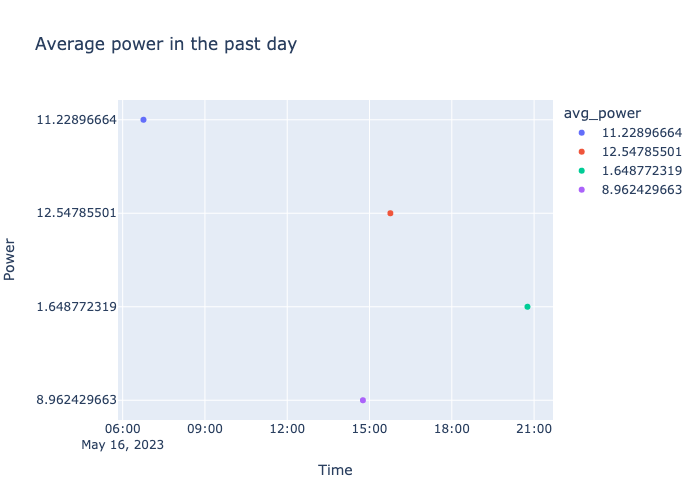
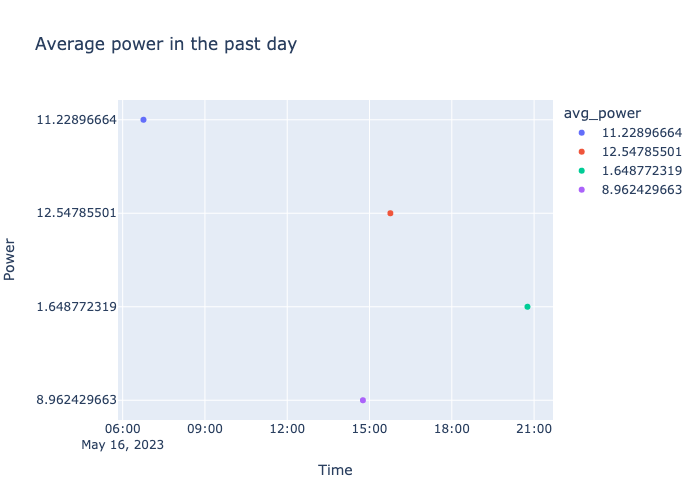
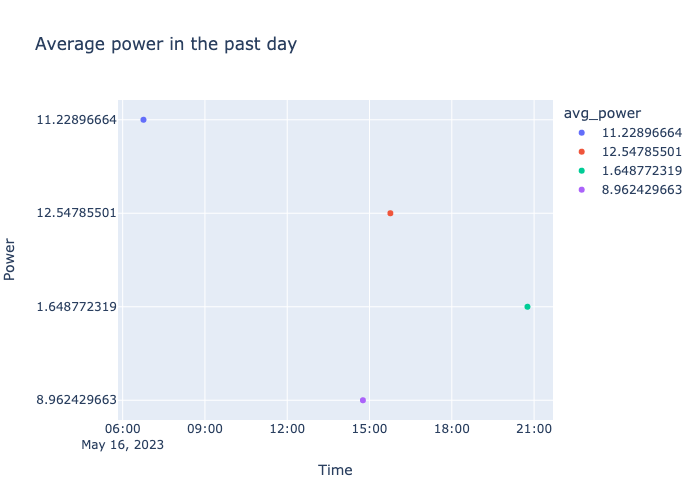
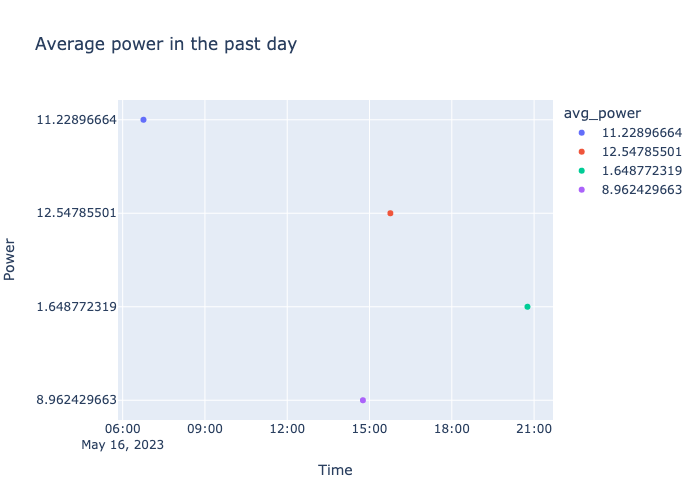

0

In [133]:

# top_section = ('<html>\n<head><style>div{color:purple;}</style>\n<title>Daily Report</title>\n<link rel="stylesheet" href="./style.css">\n</head>\n<body>\n<div class="heading">\n<h1>Daily report</h1>\n<p1>{print_line}</p1>\n</div>\n<div class="container" >')
template = (f"""<img style="width: {width}; height: {height}" src="data:image/png;base64,{image}">""")

# A collection of Plotly graphs
figures = [fig, age_fig, heart_fig, power_fig]
# Generate their images using `py.image.get`
images = [base64.b64encode(figure.to_image()).decode('utf-8') for figure in figures]

report_html = f'<html>\n{style}<head>\n<title>Daily Report</title>\n<link rel="stylesheet" href="./style.css">\n</head>\n<body>\n<div class="heading">\n<h1>Daily report</h1>\n<p1>{print_line}</p1>\n</div>\n<div class="container" >'
for image in images:
    _ = template
    _ = _.format(image=image, width=width, height=height)
    report_html += _
print(report_html)
convert_html_to_pdf(report_html, 'report-2.pdf')

In [43]:
def convert_html_to_pdf(source_html, output_filename):
    # open output file for writing (truncated binary)
    result_file = open(output_filename, "w+b")

    # convert HTML to PDF
    pisa_status = pisa.CreatePDF(
            source_html,                # the HTML to convert
            dest=result_file)           # file handle to recieve result

    # close output file
    result_file.close()                 # close output file

    # return True on success and False on errors
    return pisa_status.err